# 05c parameter optimisation 

In [1]:
#|default_exp core.05c_parameter_optimisation

In [2]:
#|export
import autograd.numpy as np
from autograd import grad, jacobian, hessian
#from scipy.special import logsumexp
from scipy.optimize import minimize
import pandas as pd
from matplotlib import pyplot as plt

from dementia_inequalities import const, log, utils, tools 

---

In [3]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [4]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.226918,48.025165,34.275376,60.412434,19.073111,6.164929,2.948652,215.158147,0.001420
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.648147,72.016965,20.177787,64.559886,10.372597,3.650571,1.287952,437.450820,0.002790
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.922160,55.139862,23.752404,62.659322,13.584680,4.848008,1.987987,123.466346,0.001299
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.996946,53.341341,23.914299,58.934576,13.640026,5.506448,2.148768,612.399689,0.004970
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.805733,48.818156,29.486050,62.572808,15.965501,6.298085,2.250735,77.360723,0.001138


In [5]:
# The real dementia x and y data 

# covariates 
covar = ['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']

# Input data 
x = np.array(df_dem_plus[covar].values.reshape(-1,7))

# Outcome data 
y = np.array(df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1))

In [6]:
def reverse_shift_log_normal_pdf(x, delta, mu, sigma):
    pdf = []
    #x_shift = delta - x
    for i, x_i in enumerate(x):
        #if isinstance(delta, int) or isinstance(delta, float):
        #    delta = delta * np.ones(len(x)).T  

        #if x_shift[i] < 0: 
        if delta[i] < x_i: 
            pdf.append(0)
        else: 
            x_shift = delta[i] - x_i
            norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
            exp_part = np.exp(-1 * (1 / (2 * sigma ** 2)) * (np.log(np.subtract(x_shift, mu)) ** 2))
            #exp_part = np.exp(-(np.log(np.subtract(x_shift, mu)) ** 2))
            pdf.append(norm_const.squeeze() * exp_part.squeeze())
            
    return np.array(pdf)

In [109]:
def log_rvs_shift_log_normal(x, delta, mu, sigma):
    #pdf = []
    pdf = np.array(np.zeros(x.shape[0]))
    #print(pdf.shape)
    #x_shift = delta - x
    for i in range(x.shape[0]):
        #if delta[i] < x_i: 
        #    pdf.append(0)

        if delta[i] >= x[i]:
        #else: 
            x_shift = (delta[i] - x[i])
            #print(x_shift)
            #print(x_shift.shape)

            part1 = (1/(2 * sigma ** 2)) * (2 * mu * np.log(x_shift) - (np.log(x_shift)) ** 2 - mu ** 2) 
            print(part1[0])

            part2 = np.log(x_shift * sigma * np.sqrt(2 *np.pi))
            print(part2[0])
            print(part1[0]-part2[0])
            print(pdf)
            pdf[i] = part1[0] - part2[0]
            print(pdf[i])
            #pdf.append(np.subtract(part1.squeeze(), part2.squeeze()))
            #norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
            #exp_part = np.exp(-1 * (1 / (2 * sigma ** 2)) * (np.log(np.subtract(x_shift, mu)) ** 2))
            #pdf[i] = part1 - part2
            
    return np.array(pdf)

def neg_loglike(params):
    beta_0 = params[0]
    beta = np.array(params[1:-2])
    mu = params[-2]
    sigma = params[-1]

    y_pred = (np.dot(x, beta)).squeeze() + beta_0
    log_likely = log_rvs_shift_log_normal(y, delta=y_pred.squeeze(), mu=mu, sigma=sigma)
    #log_likelihood = np.nan_to_num(np.log(likelihood))
    #log_likelihood = np.log(likelihood)
    
    return (-1 * np.sum(log_likely)).squeeze()

In [31]:
def log_norm_mode(mu:int, # mean of the variables log
                  sigma:int): # standard deviation of the variables log
    return np.exp(mu - sigma**2)

In [105]:
trial_params = np.array([0.25, 0.1, 0.004, -0.004, -0.003, 0.0157, -0.0138, 0.108, 0, 0.25])
print(neg_loglike(trial_params))

[-8.20667566]
[0.54547903]
[-8.75215469]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-8.752154693290098

In [76]:
A = np.zeros(3)

In [74]:
A[1]=0.456

In [77]:
A

array([0., 0., 0.])

In [110]:
jacobian_ = jacobian(neg_loglike)

print(jacobian_(trial_params))

Autograd ArrayBox with value -8.206675659336389
Autograd ArrayBox with value 0.5454790339537091
Autograd ArrayBox with value -8.752154693290098
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

ValueError: setting an array element with a sequence.

### Optimise the negative log likelihood 

We evaluate the log-likelihood using the maximise function from scikit-learn. This code is written with a little help from my firend ChatGPT - actually it generated the intial code - then I re-wrote 70% of it... 

*Note*: we need the likelihood to be the shifted log normal - which has an extra parameter (delta) compared to the log normal [see here](https://stats.stackexchange.com/questions/379980/understanding-the-shifted-log-normal-distribution). 

The shifted log-normal PDF at $x$ is: 

$$
p(x|x>\delta, \delta, \mu, \sigma) = 
\frac{1}{(x-\delta)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(x- \delta)-\mu)^2}
$$

In the log-normal distribution, 
- $\mu$ is the scale parameter - it stretches and compresses
- $\sigma$ is a shape parameter - it controls how skewed/heavy tailed the distribution is. 
- $\delta$ is the shift parameter - here the shift is the linear equation: $\delta = \beta X$.

Since, we are taking $y_i$ to represent the observed diagnoses, and $\beta X$ to represent the expected a lower bound on the true prevalence rate the equation is: 

$$
y_i=\beta X_i - \epsilon 
$$ 

Where $\epsilon > 0$. Now, accordingly the probability is: 

$$
p(y_i|y_i < \beta X_i, \beta, \mu, \sigma) = 
\frac{1}{(\beta X_i - y_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(\beta X_i - y_i)-\mu)^2}
$$

And hence, the likelihood is: 

$$
L(\delta, \mu, \sigma) = \prod_{i=1}^n s(y_i | y_i < \beta X, \beta X, \mu, \sigma) \\

= \prod_{i=1}^n \frac{1}{(\beta X_i - y_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(\beta X_i - y_i)-\mu)^2}
$$

Let $ z_i = \beta X_i -y_i $. Then we have a log likelihood of:

$$
= \sum_{i=1}^n ln(\frac{1}{z_i \sigma \sqrt{2 \pi}} exp(- \frac{(ln z_i - \mu)^2}{2 \sigma^2})) \\ 
= \sum_{i=1}^n ln(\frac{1}{z_i \sigma \sqrt{2 \pi}} ) - \frac{ln^2z_i -2\mu ln z_i + \mu^2}{2 \sigma^2} \\
= \sum_{i=1}^n - ln(z_i \sigma \sqrt{2 \pi}) - \frac{1}{2 \sigma^2}(ln^2z_i -2\mu ln z_i + \mu^2) \\
= \sum_{i=1}^n \frac{1}{2 \sigma^2}(2\mu ln z_i - ln^2 z_i - \mu^2) - ln(z_i \sigma \sqrt{2 \pi})
$$


/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_44801/1017857730.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_44801/1017857730.py:16: RuntimeWarning: invalid value encountered in scalar multiply
  pdf.append(norm_const.squeeze() * exp_part.squeeze())


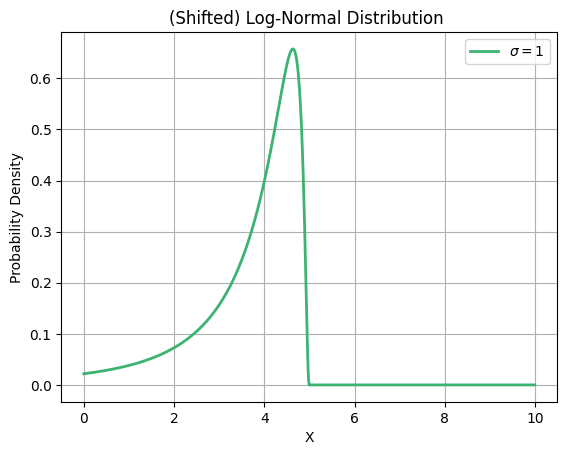

In [11]:
# Parameters for log-normal distribution
mu_0 = 0  # Mean
sigma_0 = 1
shift = 5 # Shift 

x_axis = np.arange(0, 10, 0.01)
shift = shift * np.ones(len(x_axis))

pdf_x_mu0 = reverse_shift_log_normal_pdf(x_axis, shift, mu_0, sigma_0)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x_axis, pdf_x_mu0, '-', linewidth=2, color='mediumseagreen', label='$\sigma=1$')
#plt.text(6, 0.42, '$\sigma=1$', color='mediumseagreen')
#plt.plot(x, pdf_x_mu1, '-', linewidth=2, color='slateblue', label='$\sigma=0.25$')
#plt.text(7, 0.15, '$\sigma=0.25$', color='slateblue')

plt.title('(Shifted) Log-Normal Distribution ')
plt.legend(loc='upper right')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [24]:
# n_features = 7

# np.random.seed(27)
# x0 = np.concatenate([np.random.normal(size=n_features+1), [0, 0.25]]) 

params_0 = np.array([0.25, 0.1, 0.004, -0.004, -0.003, 0.0157, -0.0138, 0.108, 0.1, 0.25])

In [25]:
# Gradient of the function
#grad_loglike = grad(neg_loglike)

# Initial guess

# Use scipy's minimize function with the BFGS algorithm
result = minimize(neg_loglike, params_0, method = 'BFGS')

result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0
        x: [ 2.415e-01 -1.172e-01 -5.314e-01 -4.270e-01 -7.002e-01
            -1.120e-01 -6.484e-02  9.091e-02  1.168e-01  2.903e-01]
      nit: 1
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 22
     njev: 2

In [26]:
# derivates of neg_loglike
jacobian_  = jacobian(neg_loglike)

#result = minimize(neg_loglike, params_0, method = 'BFGS', \
#               options={'disp': False}, jac = jacobian_)


result = minimize(neg_loglike, params_0, method='BFGS', jac = jacobian_, options={'gtol': 1e-6, 'disp':True})
result

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


TypeError: Can't find vector space for value 0 of type <class 'numpy.int64'>. Valid types are dict_keys([<class 'autograd.core.SparseObject'>, <class 'list'>, <class 'tuple'>, <class 'dict'>, <class 'numpy.ndarray'>, <class 'float'>, <class 'numpy.longdouble'>, <class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>, <class 'complex'>, <class 'numpy.clongdouble'>, <class 'numpy.complex64'>, <class 'numpy.complex128'>, <class 'numpy.linalg.linalg.EigResult'>, <class 'numpy.linalg.linalg.EighResult'>, <class 'numpy.linalg.linalg.QRResult'>, <class 'numpy.linalg.linalg.SlogdetResult'>, <class 'numpy.linalg.linalg.SVDResult'>])

In [15]:
# Extract the MLE from the parameter samples
MLE_params = result.x

MLE_intercept = MLE_params[0]
MLE_beta = MLE_params[1:-2]
MLE_mu = MLE_params[-2]
MLE_sigma = MLE_params[-1]

print("MLE estimates \n--------------\n--------------")
print(f'Intercept:{MLE_intercept}')
print("--------------\nRegression coefficients\n--------------")
for i, var in enumerate(covar):
    print(f'{var}:{MLE_beta[i]}')
print("--------------\nLog normal coefficients\n--------------")
print("Mu:", MLE_mu)
print("Sigma:", MLE_sigma)

MLE estimates 
--------------
--------------
Intercept:0.24146902872351658
--------------
Regression coefficients
--------------
over_65_pc:-0.11520889746937785
female_pc:-0.5344876178635556
ALevel_plus_pc:-0.4320213296103892
white_pc:-0.6950508627321601
HYP_afflicted_pc:-0.1114890329077417
DM_afflicted_pc:-0.06492857791075088
STIA_afflicted_pc:0.09105013908015044
--------------
Log normal coefficients
--------------
Mu: 0.016875394605133123
Sigma: 0.29736586194182324


/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


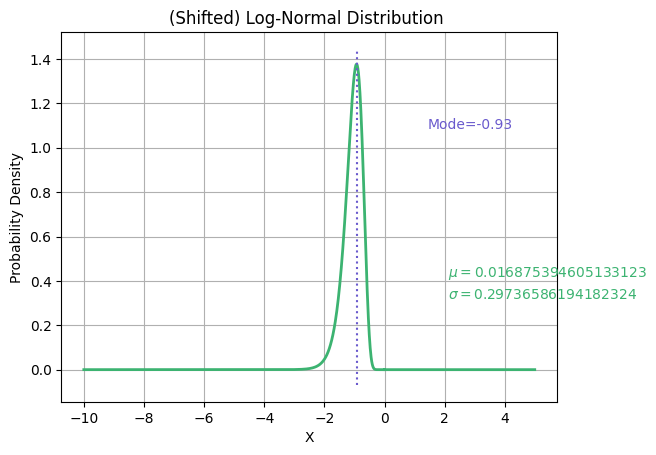

In [16]:
# mode of the log normal 
mode = log_norm_mode(MLE_mu, MLE_sigma)

# plot log normal of MLE parameters 
x_axis = np.arange(-10, 5, 0.01)
pdf_x_mu0 = reverse_shift_log_normal_pdf(x_axis, np.zeros(len(x_axis)), MLE_mu, MLE_sigma)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x_axis, pdf_x_mu0, '-', linewidth=2, color='mediumseagreen')
plt.text(2.1, 0.32, f'$\sigma=${MLE_sigma}', color='mediumseagreen')
plt.text(2.1, 0.42, f'$\mu=${MLE_mu}', color='mediumseagreen')
#plt.text(7, 0.15, '$\sigma=0.25$', color='slateblue')

ymin, ymax = plt.ylim()
plt.vlines(-mode, ymin, ymax, color='slateblue', label='Log normal mode', linestyles='dotted')
plt.text(mode+0.5, 3*ymax/4, f'Mode={np.round(-mode,2)}', color='slateblue')

plt.title('(Shifted) Log-Normal Distribution ')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [17]:
y_pred = np.dot(x, MLE_beta.T) + MLE_intercept
diagnosis_gap = y_pred.squeeze() - y.squeeze()

# update the dataframe 
df_dem_plus['diagnosis_gap']=diagnosis_gap

In [18]:
y_pred

array([-123.78194086, -112.76690946, -119.97884103, -119.76612826,
       -124.8702075 , -103.16691765, -116.97246711, -121.87241732,
       -127.82142305, -105.49006996, -113.96230554, -114.52594108,
       -104.63464113, -127.30998539, -102.33210715, -124.53700375,
       -124.43945582, -117.99010899, -109.73914439, -124.53774414,
        -84.61064047,  -83.7105258 , -114.97749209, -124.02584768,
       -123.81413122, -119.58241891, -106.2503479 , -124.47311582,
       -118.7382416 , -127.99909916, -117.95795664, -120.97865275,
        -76.18146505, -124.67652691,  -80.1381655 , -127.53534213,
       -124.78604668, -112.18471721, -127.13716843,  -98.62537303,
       -129.28312095,  -90.91595793,  -99.95748207, -118.39011337,
       -115.15702326, -122.32650932, -110.6361373 , -121.80124191,
        -93.45114997, -126.59477862, -120.54065422,  -96.63748127,
       -108.55575211, -113.18560544, -122.24534251, -124.27594837,
       -125.36836962, -110.57350729,  -79.46312993, -126.53172

In [19]:
most_bad_lads = np.argsort(diagnosis_gap)[-10:]
df_dem_plus.iloc[most_bad_lads, :][['area_name', 'diagnosis_gap']]

,area_name,diagnosis_gap
133,Enfield,-82.968444
214,Leicester,-81.803628
73,Slough,-81.789872
34,Harrow,-80.831863
58,Redbridge,-79.958289
32,Camden,-76.666766
62,Tower Hamlets,-75.199652
290,Brent,-74.258086
167,Westminster,-70.987526
284,Newham,-69.492424


In [20]:
least_bad_lads = np.argsort(diagnosis_gap)[:10]
df_dem_plus.iloc[least_bad_lads, :][['area_name', 'diagnosis_gap']]

,area_name,diagnosis_gap
40,South Hams,-130.089936
29,East Devon,-129.381468
8,Ribble Valley,-128.616972
35,West Devon,-128.548474
83,Winchester,-128.459006
183,Waverley,-128.327223
13,Hambleton,-128.296457
219,Malvern Hills,-128.292430
196,East Hampshire,-128.162811
239,Cotswold,-128.149230


## Evaluating the Fisher information at the MLE 

In [21]:
hessian_ = hessian(neg_loglike)

print(hessian_(MLE_params))

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


TypeError: Can't find vector space for value 0 of type <class 'numpy.int64'>. Valid types are dict_keys([<class 'autograd.core.SparseObject'>, <class 'list'>, <class 'tuple'>, <class 'dict'>, <class 'numpy.ndarray'>, <class 'float'>, <class 'numpy.longdouble'>, <class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>, <class 'complex'>, <class 'numpy.clongdouble'>, <class 'numpy.complex64'>, <class 'numpy.complex128'>, <class 'numpy.linalg.linalg.EigResult'>, <class 'numpy.linalg.linalg.EighResult'>, <class 'numpy.linalg.linalg.QRResult'>, <class 'numpy.linalg.linalg.SlogdetResult'>, <class 'numpy.linalg.linalg.SVDResult'>])

In [ ]:
def is_neg_def(x):
    return np.all(np.linalg.eigvals(x) <= 0)

In [ ]:
np.linalg.eigvals(hessian_(MLE_params))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
is_neg_def(hessian_(MLE_params))

True